# Load Dependencies

In [1]:
from Script.utils import *
from Script.figure import *
from joblib import Parallel, delayed

# Load Data

In [2]:
data_dir = './Data/data_cc/'
rundata_dir = './Data/rundata_cc/'
df=pd.read_csv(data_dir+"experiment_index_order.csv")
df = df.sort_values(by='yield')
ele_smi=df['Electrophile_SMILES'].tolist()
nuc_smi=df['Nucleophile_SMILES'].tolist()
lig_smi=df['Ligand_SMILES'].tolist()
base_smi=df['Base_SMILES'].tolist()
sol_smi=df['Solvent_SMILES'].tolist()
yield_value=df['yield'].tolist()

In [ ]:
target = 'yield'
defined_chemical_space = {'Electrophile_SMILES':sorted(list(set(ele_smi))), 
                          'Nucleophile_SMILES':sorted(list(set(nuc_smi))), 
                          'Ligand_SMILES':sorted(list(set(lig_smi))),
                          'Base_SMILES':sorted(list(set(base_smi))), 
                          'Solvent_SMILES':sorted(list(set(sol_smi))), 
                          }
domain = df.drop(['yield','entry'],axis=1)
print('The size of chemical space is: %d'%len(domain))
des_name = 'dft'#'ohe','mordred','dft','alldes'
desc_map={}
if des_name not in ['ohe','mordred','dft','alldes']:
    print('Error: The selected descriptor is not supported.')
elif des_name == 'alldes':
    desc_map = np.load('./Data/data_cc/all_desc_map.npy',allow_pickle=True).item()
else:
    for i in glob.glob(data_dir+'*.csv'):
        if i.split('/')[-1].split('.')[0].split('_')[-1]==des_name:     
            tem_data=np.array(pd.read_csv(i))
            for j in range(len(tem_data)):
                desc_map[tem_data[j][0]]=tem_data[j][1:]                                   
desc_domain = getdescdomain(domain,desc_map,defined_chemical_space)

The size of chemical space is: 3696


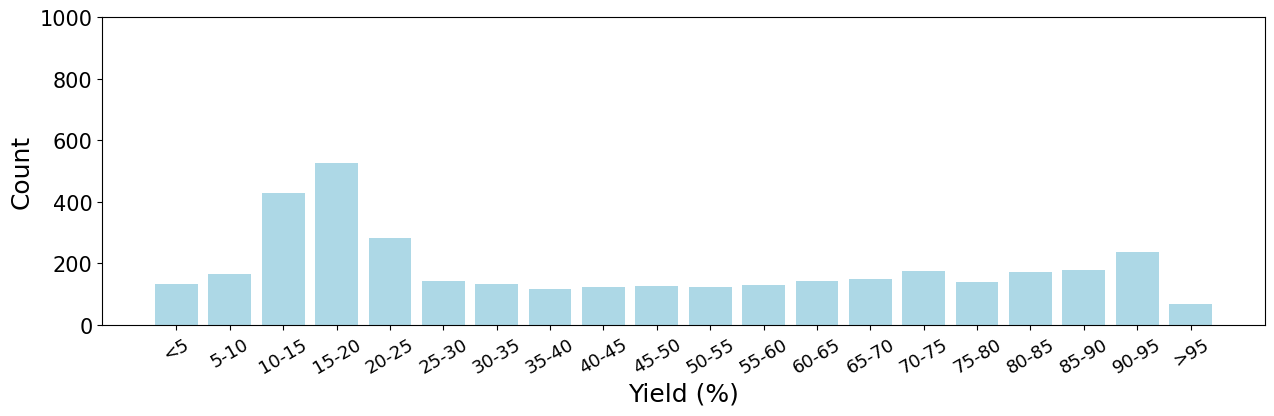

In [4]:
ee_distrib_group = {0.05:0,0.1:0,0.15:0,0.2:0,0.25:0,0.3:0,0.35:0,0.4:0,0.45:0,0.5:0,0.55:0,
                    0.6:0,0.65:0,0.7:0,0.75:0,0.8:0,0.85:0,0.9:0,0.95:0,1.0:0}
for i in yield_value:
    for key in ee_distrib_group:
        if i/100 < key:
            ee_distrib_group[key] += 1
            break
        
fig = plt.figure(figsize=(15,4))
tick_fontsize = 15
label_fontsize = 18
plt.bar(list(range(len(ee_distrib_group))),[ee_distrib_group[key] for key in ee_distrib_group],color='lightblue')
plt.xticks(list(range(len(ee_distrib_group))),
           ['<5','5-10','10-15','15-20','20-25','25-30','30-35','35-40','40-45','45-50','50-55','55-60',
            '60-65','65-70','70-75','75-80','80-85','85-90','90-95','>95'],
          fontsize=13,rotation=30)
plt.yticks([0,200,400,600,800,1000],["0",'200','400','600','800','1000'],fontsize=tick_fontsize)
plt.xlabel('Yield (%)',fontsize=label_fontsize)
plt.ylabel('Count',fontsize=label_fontsize)
print()

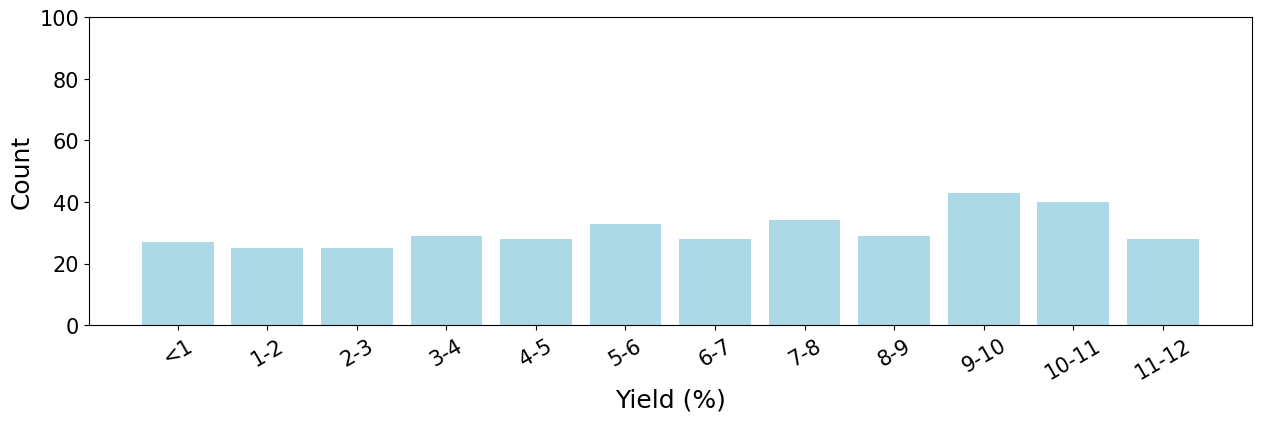

In [5]:
ee_distrib_group = {0.01:0,0.02:0,0.03:0,0.04:0,0.05:0,0.06:0,0.07:0,0.08:0,0.09:0,0.1:0,0.11:0,0.12:0}
for i in yield_value[:int(3696*0.1)]:
    for key in ee_distrib_group:
        if i/100 < key:
            ee_distrib_group[key] += 1
            break
        
fig = plt.figure(figsize=(15,4))
tick_fontsize = 15
label_fontsize = 18
plt.bar(list(range(len(ee_distrib_group))),[ee_distrib_group[key] for key in ee_distrib_group],color='lightblue')
plt.xticks(list(range(len(ee_distrib_group))),
           ['<1','1-2','2-3','3-4','4-5','5-6','6-7','7-8','8-9','9-10','10-11','11-12'],
          fontsize=tick_fontsize,rotation=30)
plt.yticks([0,20,40,60,80,100],["0",'20','40','60','80','100'],fontsize=tick_fontsize)
plt.xlabel('Yield (%)',fontsize=label_fontsize)
plt.ylabel('Count',fontsize=label_fontsize)
print()

# Reaction Optimization

In [8]:
cc1 = 5
cc2 = 4
cc3 = 3
cc4 = 2
cc1_rate = 0.5 # 0-1 exploration proportion of the first Stage
cc2_rate = 0.5 # 0-1 exploration proportion of the second Stage
cc3_rate = 0.5 # 0-1 exploration proportion of the second Stage
cc4_rate = 0.5 
random_state = 0
data_name = 'cc'
des_name = 'dft' #'ohe','mordred','dft','alldes'
model = 'Ridge' #'DT','ET','GB','KNR','KRR','LSVR','RF','Ridge'
print_seed = False
external_init = 'low_rate10'#'low_rate10','low_rate20','low_rate30','low_rate40'...

task = f'{data_name}-ourwork-{cc1}-{cc2}-{cc3}-{cc4}-{int(cc1_rate*100)}-{int(cc2_rate*100)}-{int(cc3_rate*100)}-{int(cc4_rate*100)}-{external_init}'
norun_seed = []
for seed in range(100):
    #if os.path.exists(rundata_dir+f'results_optimization/{task}_{des_name}_{model}_{seed}.npy'):   
        #continue  
    #else:
    norun_seed.append(seed)
print(norun_seed)
Parallel(n_jobs=-1)(delayed(reaction_optimization_single_line)(seed=seed, domain = domain, desc_domain = desc_domain, model = model, \
    des_name = des_name,cc1=cc1,cc2=cc2,cc3=cc3,cc4=cc4,cc1_rate=cc1_rate, cc2_rate=cc2_rate,cc3_rate=cc3_rate,cc4_rate=cc4_rate,\
    task = task,print_seed=print_seed,data_name = data_name) for seed in norun_seed) 
total_results = get_total_results(rundata_dir+f'results_optimization/{task}_{des_name}_{model}_*.npy',start=0,end=100,save_dir= './Results/results_'+data_name+ '/') 

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
Data save in: ./Results/results_cc/cc-ourwork-5-4-3-2-50-50-50-50-low_rate10_dft_Ridge_total.npy
